<a href="https://colab.research.google.com/github/nikhilkarnwal/projects/blob/master/semantic_segmentation_deeplearning_BSDS_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
#!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-human.tgz
#!tar zxvf *-images.tgz
#!ls
#!mv BSDS300 /content/drive/My\ Drive/ColabData/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import os
import torchvision.transforms as tf
import matplotlib.pyplot as plt
import torch as th
from PIL import Image
import re
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [0]:
def get_seg(file):
  with open(file, "r") as seg_file:
    d_seen = False
    header = {}
    image = np.full((500,500),33,dtype=np.int16)
    for line in seg_file:
      if not d_seen:
        if('data' in line):
          d_seen = True
        else:
          header[line.split(' ')[0]]=re.split(' |\n',line)[1]
      else:
        col = np.asarray(line.split(' '),dtype=np.int64)
        image[col[1],col[2]:(col[3]+1)]=col[0] if col[0]< 21 else 33
  return header['image'], image[:int(header['height']),:int(header['width'])]

In [0]:
fig=0
def show_tensor(img_tensor):
  plt.figure()
  plt.imshow(tf.Resize(224)(tf.ToPILImage(mode=None)(img_tensor.to(th.float))))

In [5]:
class DataSet:
  size = (224,224)
  def __init__(self, image_train, image_test, label, base_path):
    self.im_train = image_train
    self.im_test = image_test
    self.label = label
    self.base_path = base_path
  
  def get_img_feat(self, img_dir):
    print("def get_img_feat---")
    cnt=0
    img_feats = {}
    trf = tf.Compose([tf.Resize(self.size),
                      tf.ToTensor(), 
                      tf.Normalize(mean = [0.485, 0.456, 0.406], 
                                   std = [0.229, 0.224, 0.225])])
    for img in os.listdir(img_dir):
      #print(img)
      img_path = os.path.join(img_dir,img);
      img_tensr = trf(Image.open(img_path))
      img_feats[img.split('.')[0]]=img_tensr
      cnt=cnt+1
      if cnt%100 == 0:
        print("Cnt - ", cnt)
    return img_feats

  def get_seg_labels(self):
    print("def get_seg_labels---")
    cnt=0
    seg_labels = {}
    trf = tf.Compose([tf.ToPILImage(mode=None),
                      tf.Resize(self.size)])
    for user in os.listdir(self.label):
      user_dir = os.path.join(self.label,user)
      for seg in os.listdir(user_dir):
        seg_path = os.path.join(user_dir,seg)
        img_id, seg_label = get_seg(seg_path)
        #print(img_id)
        seg_tensor = tf.ToTensor()(np.array(trf(th.from_numpy(seg_label).to(th.int)), dtype=np.int16))
        if img_id not in seg_labels:
          seg_labels[img_id]=[]
        seg_labels[img_id].append(seg_tensor)
        cnt=cnt+1
        if cnt%100 == 0:
          print("Cnt - ", cnt)
    return seg_labels

  def gen_data(self):
    train_feat = self.get_img_feat(self.im_train)
    test_feat = self.get_img_feat(self.im_test)
    seg_labels = self.get_seg_labels()
    train_data = []
    train_label = []
    test_data = []
    test_label = []
    print("Augmenting Data")
    for id in seg_labels:
      for seg_lab in seg_labels[id]:
        if id in train_feat and len(train_data)<1500:
          train_data.append(np.array(train_feat[id]))
          train_label.append(np.array(seg_lab))
        if id in test_feat and len(test_data) < 500:
          test_data.append(np.array(test_feat[id]))
          test_label.append(np.array(seg_lab))
    
    self.train_data = np.array(train_data)
    self.train_label = np.array(train_label)
    self.test_data = np.array(test_data)
    self.test_label = np.array(test_label)

  def save_data(self):
    print("Saving Data")
    np.save(os.path.join(self.base_path,"train_data"), self.train_data);
    np.save(os.path.join(self.base_path,"train_label"), self.train_label);
    np.save(os.path.join(self.base_path,"test_data"), self.test_data);
    np.save(os.path.join(self.base_path,"test_label"), self.test_label);

  def load_data(self):
    print("Loading Data")
    self.train_data = np.load(os.path.join(self.base_path,"train_data.npy"));
    self.train_label = np.load(os.path.join(self.base_path,"train_label.npy"));
    self.test_data = np.load(os.path.join(self.base_path,"test_data.npy"));
    self.test_label = np.load(os.path.join(self.base_path,"test_label.npy"));

  def get_data(self,old=False):
    if old:
      self.load_data()
    else:
      self.gen_data()
      self.save_data()

base_dir = "/content/drive/My Drive/ColabData/BSDS300"
base_gendata = os.path.join(base_dir,'GenData') 
images = os.path.join(base_dir,'images')
train = os.path.join(images,'train')
test = os.path.join(images,'test')
label = os.path.join(base_dir,'human/color')
dataset = DataSet(train,test,label,base_gendata)
dataset.get_data(True)
print(dataset.train_data.shape)
print(dataset.train_label.shape)
print(dataset.test_data.shape)
print(dataset.test_label.shape)


Loading Data
(1087, 3, 224, 224)
(1087, 1, 224, 224)
(500, 3, 224, 224)
(500, 1, 224, 224)


In [0]:
class SSCNNet_Orignal(nn.Module):
    @staticmethod
    def conv(in_chan, out_chan, ks=3, stride=1, pad=1):
        conv = nn.Conv2d(in_chan, out_chan, kernel_size=ks, stride=stride,
                         padding=pad)
        return conv

    def __init__(self):
        super(SSCNNet, self).__init__()
        self.conv1_1 = self.conv(3, 64, pad=100)
        self.conv1_2 = self.conv(64, 64)

        self.conv2_1 = self.conv(64, 128)
        self.conv2_2 = self.conv(128, 128)

        self.conv3_1 = self.conv(128, 256)
        self.conv3_2 = self.conv(256, 256)
        self.conv3_3 = self.conv(256, 256)

        self.conv4_1 = self.conv(256, 512)
        self.conv4_2 = self.conv(512, 512)
        self.conv4_3 = self.conv(512, 512)

        self.conv5_1 = self.conv(512, 512)
        self.conv5_2 = self.conv(512, 512)
        self.conv5_3 = self.conv(512, 512)

        self.fc6 = self.conv(512, 4096, 7, pad=0)
        self.fc7 = self.conv(4096, 4096, 1, pad=0)

        self.final_conv = self.conv(4096, 21, 1, pad=0)
        self.deconv = nn.ConvTranspose2d(21, 21, kernel_size=4, stride=2, bias=False)

        # skip layer 1
        self.final_conv3 = self.conv(self.conv3_3.out_channels, 21, ks=1, pad=0)
        self.deconv3 = nn.ConvTranspose2d(21, 21, kernel_size=16, stride=8, bias=False)

        # skip layer 2
        self.final_conv4 = self.conv(self.conv4_3.out_channels, 21, ks=1, pad=0)
        self.deconv4 = nn.ConvTranspose2d(21, 21, kernel_size=4, stride=2, bias=False)

        # softmax layer
        self.softmax_lyr = nn.Softmax2d()

    def forward(self, x):
        start_img = x
        # conv1
        x = F.max_pool2d(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))), (2, 2), 2)

        # conv2
        x = F.max_pool2d(F.relu(self.conv2_2(F.relu(self.conv2_1(x)))), (2, 2), 2)

        # conv3
        x = F.relu(self.conv3_3(F.relu(self.conv3_2(F.relu(self.conv3_1(x))))))
        pool3 = F.max_pool2d(x, (2, 2), 2)

        # conv4
        x = F.relu(self.conv4_3(F.relu(self.conv4_2(F.relu(self.conv4_1(pool3))))))
        pool4 = F.max_pool2d(x, (2, 2), 2)

        # conv5
        x = F.relu(self.conv5_3(F.relu(self.conv5_2(F.relu(self.conv5_1(pool4))))))
        x = F.max_pool2d(x, (2, 2), 2)

        # fc6
        x = F.dropout2d(F.relu(self.fc6(x)), p=0.5, inplace=True)
        # fc7
        x = F.dropout2d(F.relu(self.fc7(x)), p=0.5, inplace=True)

        # final
        up_sample_2 = F.relu(self.deconv(F.relu(self.final_conv(x))))

        # pool4 skip
        skip4 = F.relu(self.final_conv4(pool4))
        croped_conv4 = F.pad(skip4,(0, -skip4.shape[-1] + up_sample_2.shape[-1], 0,
                                        -skip4.shape[-2] + up_sample_2.shape[-2]))
        fuse_pool4 = th.add(croped_conv4, up_sample_2)
        up_sample_4 = F.relu(self.deconv4(fuse_pool4))

        # pool3 skip
        skip3 = F.relu(self.final_conv3(pool3))
        croped_conv3 = F.pad(skip3, (0, -skip3.shape[-1] + up_sample_4.shape[-1], 0,
                                        -skip3.shape[-2] + up_sample_4.shape[-2]))
        fuse_pool3 = th.add(croped_conv3, up_sample_4)
        up_sample_8 = F.relu(self.deconv3(fuse_pool3))

        # final softmax layer
        softmax_last = up_sample_8
        width_gap = start_img.shape[-1] - softmax_last.shape[-1]
        height_gap = start_img.shape[-2] - softmax_last.shape[-2]
        cropped_last = F.pad(softmax_last,(0,width_gap,0,height_gap))
        return self.softmax_lyr(cropped_last)


In [0]:
class SSCNNet(nn.Module):
    @staticmethod
    def conv(in_chan, out_chan, ks=3, stride=1, pad=1):
        conv = nn.Conv2d(in_chan, out_chan, kernel_size=ks, stride=stride,
                         padding=pad)
        return conv

    def __init__(self):
        super(SSCNNet, self).__init__()
        # Load pretrained model
        self.vgg16 = models.vgg16(pretrained=True).features
        self.vgg16.requires_grad_(False)
        self.fc6 = self.conv(512, 4096, 7, pad=0)
        self.fc7 = self.conv(4096, 4096, 1, pad=0)

        self.final_conv = self.conv(4096, 21, 1, pad=0)
        self.deconv = nn.ConvTranspose2d(21, 21, kernel_size=4, stride=2, bias=False)

        # skip layer 1
        self.final_conv3 = self.conv(self.vgg16[14].out_channels, 21, ks=1, pad=0)
        self.deconv3 = nn.ConvTranspose2d(21, 21, kernel_size=16, stride=8, bias=False)

        # skip layer 2
        self.final_conv4 = self.conv(self.vgg16[21].out_channels, 21, ks=1, pad=0)
        self.deconv4 = nn.ConvTranspose2d(21, 21, kernel_size=4, stride=2, bias=False)

        # softmax layer
        self.softmax_lyr = nn.Softmax2d()

    def forward(self, x):
        start_img = x
        
        #Add 99 pad to have 100 as vgg16 add 1 pad
        x = F.pad(x,(99,99,99,99))
        for name, child in self.vgg16.named_children():
          x=child(x)
          if int(name) is 16:
            pool3=x
          if int(name) is 23:
            pool4=x 

        # fc6
        x = F.dropout2d(F.relu(self.fc6(x)), p=0.5, inplace=True)
        # fc7
        x = F.dropout2d(F.relu(self.fc7(x)), p=0.5, inplace=True)

        # final
        up_sample_2 = F.relu(self.deconv(F.relu(self.final_conv(x))))

        # pool4 skip
        skip4 = F.relu(self.final_conv4(pool4))
        croped_conv4 = F.pad(skip4,(0, -skip4.shape[-1] + up_sample_2.shape[-1], 0,
                                        -skip4.shape[-2] + up_sample_2.shape[-2]))
        fuse_pool4 = th.add(croped_conv4, up_sample_2)
        up_sample_4 = F.relu(self.deconv4(fuse_pool4))

        # pool3 skip
        skip3 = F.relu(self.final_conv3(pool3))
        croped_conv3 = F.pad(skip3, (0, -skip3.shape[-1] + up_sample_4.shape[-1], 0,
                                        -skip3.shape[-2] + up_sample_4.shape[-2]))
        fuse_pool3 = th.add(croped_conv3, up_sample_4)
        up_sample_8 = F.relu(self.deconv3(fuse_pool3))

        # final softmax layer
        softmax_last = up_sample_8
        width_gap = start_img.shape[-1] - softmax_last.shape[-1]
        height_gap = start_img.shape[-2] - softmax_last.shape[-2]
        cropped_last = F.pad(softmax_last,(0,width_gap,0,height_gap))
        return self.softmax_lyr(cropped_last)

In [0]:
def backprop_deep(xtrain, ltrain, net, T, B=100, gamma=.001, rho=.9):
    N = xtrain.size()[0]  # Training set size
    NB = B  # Number of minibatches
    batch_size = int(N / NB);
    criterion = nn.CrossEntropyLoss(ignore_index=33)
    optimizer = th.optim.SGD(net.parameters(), lr=0.001, momentum=rho)
    for epoch in range(T):
        running_loss = 0.0
        shuffled_indices = th.randint(0, N, (N,))
        for k in range(NB):
            # Extract k-th minibatch from xtrain and ltrain
            minibatch_indices = shuffled_indices[k * batch_size:(k + 1) * batch_size]
            inputs = xtrain[minibatch_indices, :, :, :]
            labels = ltrain[minibatch_indices]
            # Initialize the gradients to zero
            optimizer.zero_grad()
            # Forward propagation
            outputs = net(inputs)
            #print(th.unique(outputs))
            #print(labels)
            # Error evaluation
            loss = criterion(outputs, labels)
            # Back propagation
            loss.backward()
            # Parameter update
            optimizer.step()
            # Print averaged loss per minibatch every 100 mini-batches
            # Compute and print statistics
            with th.no_grad():
                running_loss += loss.item()
                #print(loss.item())
            if k % 20 == (20-1):
                print('[%d, %5d] loss: %f' %
                      (epoch + 1, k + 1, running_loss / 100))
                running_loss = 0.0

In [15]:

device = 'cuda' if th.cuda.is_available() else 'cpu'
print(device)
train = th.from_numpy(dataset.train_data).to(device)
ltrain = th.from_numpy(dataset.train_label).squeeze().to(dtype=th.long)
test = th.from_numpy(dataset.test_data).to(device)
ltest = th.from_numpy(dataset.test_label).squeeze().to(dtype=th.long)
ltrain[ltrain>=20]=20
ltrain = ltrain.to(device)
ltest[ltest>=20]=20
ltest = ltest.to(device)

cuda


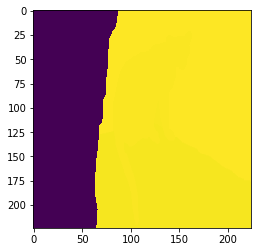

In [16]:
show_tensor(ltrain[0].to('cpu'))

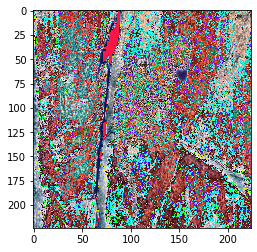

In [17]:
show_tensor(train[0].to('cpu'))

In [10]:
net = SSCNNet().to(device)
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 302MB/s]


SSCNNet(
  (vgg16): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [11]:
backprop_deep(train,ltrain,net,500,50)
model_path = base_gendata+'/model_net_t500_lre3.pth'
th.save(net.state_dict(), model_path)

[1,    20] loss: 0.608885
[1,    40] loss: 0.608890
[2,    20] loss: 0.608887
[2,    40] loss: 0.608886
[3,    20] loss: 0.608884
[3,    40] loss: 0.608883
[4,    20] loss: 0.608881
[4,    40] loss: 0.608883
[5,    20] loss: 0.608880
[5,    40] loss: 0.608874
[6,    20] loss: 0.608877
[6,    40] loss: 0.608877
[7,    20] loss: 0.608874
[7,    40] loss: 0.608876
[8,    20] loss: 0.608871
[8,    40] loss: 0.608872
[9,    20] loss: 0.608869
[9,    40] loss: 0.608868
[10,    20] loss: 0.608866
[10,    40] loss: 0.608869
[11,    20] loss: 0.608865
[11,    40] loss: 0.608858
[12,    20] loss: 0.608860
[12,    40] loss: 0.608857
[13,    20] loss: 0.608856
[13,    40] loss: 0.608860
[14,    20] loss: 0.608856
[14,    40] loss: 0.608853
[15,    20] loss: 0.608847
[15,    40] loss: 0.608849
[16,    20] loss: 0.608852
[16,    40] loss: 0.608853
[17,    20] loss: 0.608843
[17,    40] loss: 0.608841
[18,    20] loss: 0.608848
[18,    40] loss: 0.608837
[19,    20] loss: 0.608837
[19,    40] loss: 0

torch.Size([10, 21, 224, 224])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


IndexError: ignored

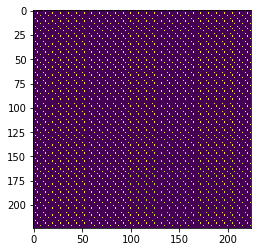

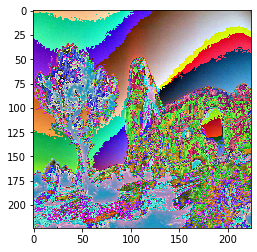

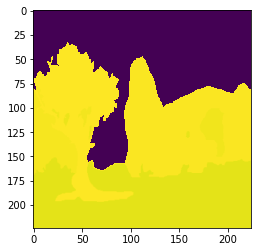

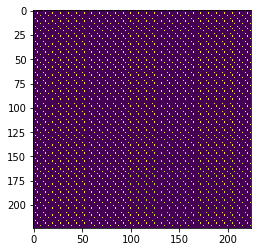

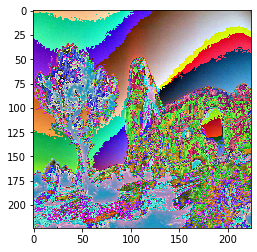

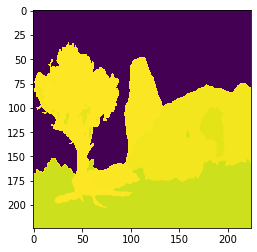

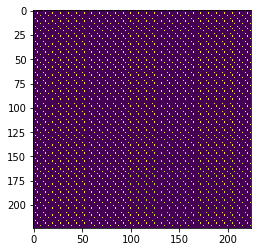

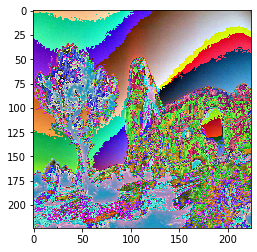

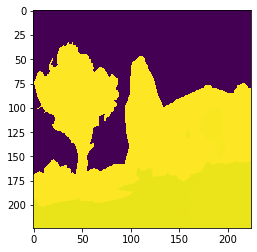

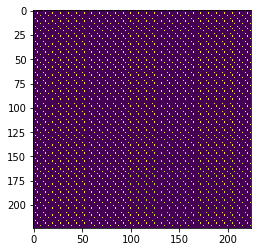

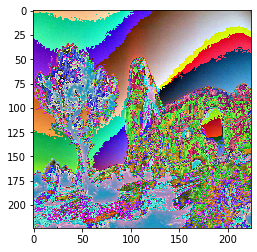

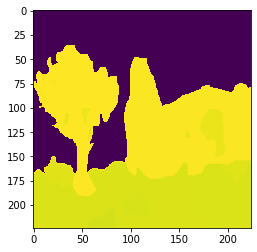

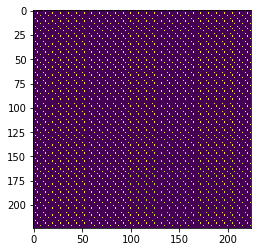

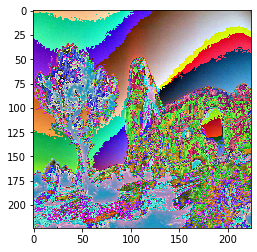

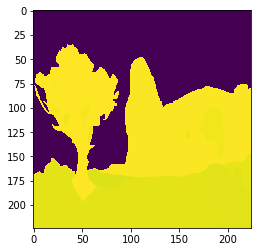

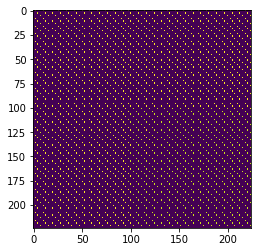

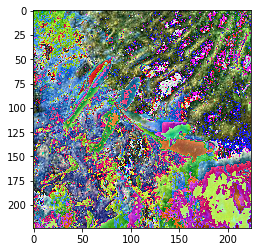

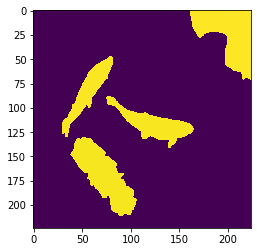

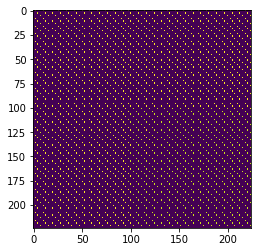

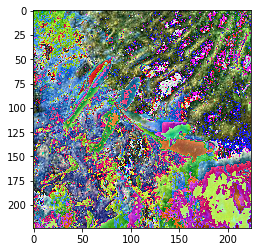

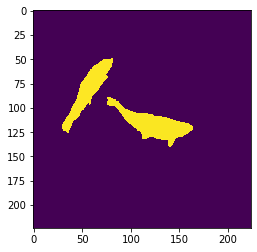

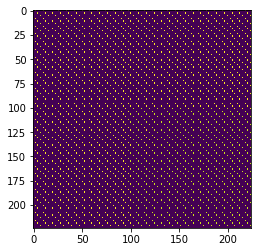

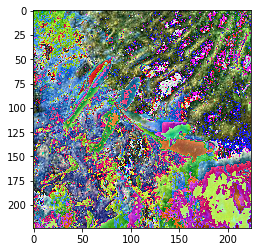

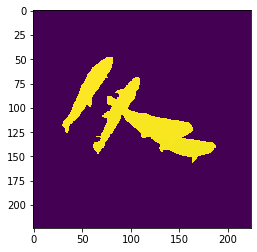

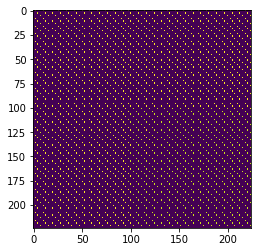

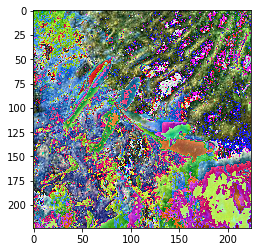

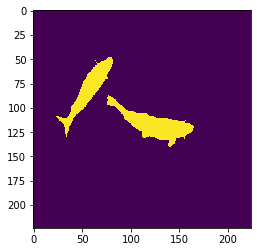

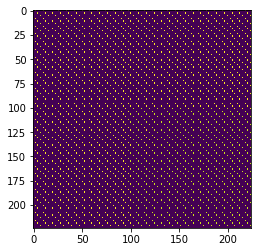

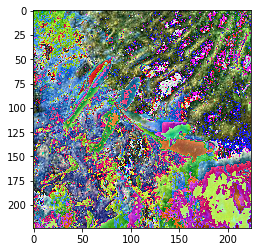

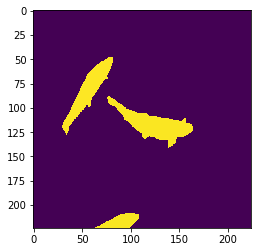

In [18]:
n_net = SSCNNet().to(device)
n_net.load_state_dict(th.load(model_path,map_location=device))
n_net.eval()
i=10
j=20
with th.no_grad():
    yinit = n_net(test[i:j])
    print(yinit.shape)
    for k in range(j-i+1):
      lpred = th.argmax(yinit[k],0)
      #print(lpred)
      show_tensor(lpred.to('cpu'))
      show_tensor(test[i+k].to('cpu'))
      show_tensor(ltest[i+k].to('cpu'))

In [0]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
for name, child in vgg16.named_children():
    for x,y in child.named_children():
      if int(x) is 5:
        print(name,x)